In [1]:
cd /home/tkim/Academics/DistMEC/

/home/tkim/Academics/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [3]:
def sum_reward_collisions(Users,T):
    save_array = np.zeros([len(Users),T])
    
    for t in range(T-1):
        for u in range(len(Users)):
            save_array[u,t] = (1 - Users[u].history_collisions[t]) * np.sum(Users[u].history_reward[t])
    
    return save_array

def generate_FL_mu(num_users,num_servers):
    mu = np.zeros([num_users,num_servers])
    svr_mu = np.random.uniform(low=0.6, high = 1, size = num_servers)
    usr_mu = np.random.uniform(low=0.75, high = 1, size = num_users)
    
    for u in range(num_users):
        for s in range(num_servers):
            mu[u,s] = svr_mu[s] * usr_mu[u]
    return mu

In [37]:
# System Parameters
T = 1000
num_users = 16
num_svrs = 16
num_svrs_loc = 16
num_locs = 9
# mu = np.random.uniform(low=0.5, high = 1, size = [num_users, num_svrs])
mu = generate_FL_mu(num_users,num_svrs)
ceiling = 40
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big
svr_offset_uniform = 1
max_dist = 5.0

num_explore = 1
trials = 1

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_16_ceiling_20_5/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)


# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs,offset = 1.7)

with open('traces_P_40k.pkl', 'rb') as handle:
    P_collection = pickle.load(handle)
    
with open('traces_P_40k_dict.pkl', 'rb') as handle:
    P_dict = pickle.load(handle)

In [78]:
# Recording Mechanism
reward_worst_dict = {}
collisions_worst_dict = {}

reward_rsv_dict = {}
collisions_rsv_dict = {}

reward_opt_stat = {}

    
for tri in range(trials):
    svr_locs = gen_rand_locs(space_1d=space_1d_dim - svr_offset_uniform, nums=num_svrs_loc)
    # Create Users
    Users_w = []
    for i in range(num_users):
        P_temp = P_collection
        Users_w += [User(usr_locs,svr_locs,mu[i],i,
                      max_dist = max_dist, threshold_dist = 6, self_weight = 1 - 0.85, P = P_temp, ceiling = 1,
                      sticky_mode = True, kick_mode=True)]

    GoT_Users = []
    for i in range(num_users):
        GoT_Users += [GoT_User(usr_locs, svr_locs, mu[i], i, 
                     max_dist = max_dist, threshold_dist = 6, self_weight = 1 - 0.95, P = Users_w[i].P,
                     c1 = 5000, c2 = 6000, c3 = 6000, delta = 0, rho = 0.5, epsilon = 0.1,
                     c = num_users, horizon = T)]
    
    # Create Servers
    Servers = []
    for i in range(num_svrs):
        Servers += [Server(svr_locs[i],mu,i)]
    
    # Recorded Values - reservation
    regret_g = np.zeros(T) # Got
    collision_count_g = np.zeros(T)
    optimal_reward_g = np.zeros(T)

    regret_w = np.zeros(T) # Worst
    collision_count_w = np.zeros(T)
    optimal_reward = np.zeros(T)
    
    # Explore rounds are common/shared across all users
    explore_rounds(Users_w, num_users, Servers, mu, regret_w, collision_count_w, optimal_reward,
                   usr_move_flag = True, rounds=num_explore, skip_optimal = True)
    explore_rounds(GoT_Users, num_users, Servers, mu, regret_w, collision_count_g, optimal_reward,
                   usr_move_flag = True, rounds=num_explore, skip_optimal = True)

    round_start = ((num_svrs)*num_explore)+1
    copy_usr_loc(Users_w, GoT_Users)
    
    # Other reward recodings
    Users_rsv = copy.deepcopy(Users_w)
    regret_rsv = copy.deepcopy(regret_w)
    collision_count_rsv = copy.deepcopy(collision_count_w)
    for u in Users_rsv:
        u.sticky_mode = True
        u.kick_mode = True #false
        u.ceiling = ceiling
        u.expected_time_true = u.get_expected_time()

    # Centralized - true w learning
    rewards_record_ct, pulls_record_ct, ucb_ct = extract_centralized_case(Users_w, num_users, num_svrs)
    regret_ct = copy.deepcopy(regret_w)
    
    # Centralized - stationary w learning
    rewards_record_cs, pulls_record_cs, ucb_cs = extract_centralized_case(Users_w, num_users, num_svrs)
    regret_cs = copy.deepcopy(regret_w)

    # Centralized - stationary w, known mu
    w_stat = obtain_w_stationary(Users_w, num_users, num_svrs)
    optimal_stat_arms, optimal_stat_reward = offline_optimal_action(w_stat,mu)
    regret_cst = copy.deepcopy(regret_w)

    for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
        w = obtain_w(Users_w, len(Users_w), len(Servers))
#         optimal = offline_optimal_action(w, mu)
#         optimal_reward[t] = optimal[1]
        optimal = optimal_stat_arms, optimal_stat_reward
        
        # Distributed solution 
        play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
                   usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal)
        play_round(Users_rsv, Servers, mu, regret_rsv, collision_count_rsv, 
                   usr_move_flag = False, debugger = False, reservation_mode = True, optimal =optimal, t = t)
        play_round(GoT_Users, Servers, mu, regret_g, collision_count_g, 
                   usr_move_flag = False, debugger=False, reservation_mode = False, optimal=optimal, t = t,
                  arms_override = optimal_stat_arms)
        copy_usr_loc(Users_w, GoT_Users)
        copy_usr_loc(Users_w, Users_rsv)

#         # Centralized Solution -  true w learning
#         ucb_ct = update_ucb(rewards_record_ct, pulls_record_ct, ucb_ct, t, 1)
#         arms = offline_optimal_action(w, ucb_ct)[0]
#         rewards_record_ct, pulls_record_ct = pull_super_arm(arms, mu, rewards_record_ct, pulls_record_ct)
#         regret_ct[t] = optimal[1] - expected_reward(arms, mu, w)
        
        # Centralized Solution -  stationary w learning
#         ucb_cs = update_ucb(rewards_record_cs, pulls_record_cs, ucb_cs, t, 1)
#         arms = offline_optimal_action(w_stat, ucb_cs)[0]
#         rewards_record_cs, pulls_record_cs = pull_super_arm(arms, mu, rewards_record_cs, pulls_record_cs)
#         regret_cs[t] = optimal[1] - expected_reward(arms, mu, w)
        
        # centralized solution - stationary w, known mu
#         regret_cst[t] = optimal[1] - expected_reward(optimal_stat_arms, mu, w) 

#     regret_centralized_dict[tri] = copy.deepcopy(regret_ct)

#     regret_worst_dict[tri] = copy.deepcopy(regret_w)
#     collisions_worst_dict[tri] = copy.deepcopy(collision_count_w)

#     regret_rsv_dict[tri] = copy.deepcopy(regret_rsv)
#     collisions_rsv_dict[tri] = copy.deepcopy(collision_count_rsv)

#     regret_cent_stat[tri] = copy.deepcopy(regret_cs)
#     regret_opt_stat[tri] = copy.deepcopy(regret_cst)

#     # Alter GoT data to be algorithm accurate
#     regret_g[11000:] = regret_cs[11000:]
#     collision_count_g[11000:] = 0
# #     collision_count_g[5000:11000] = 0.5
    
#     regret_got[tri] = copy.deepcopy(regret_g)
#     collisions_got[tri] = copy.deepcopy(collision_count_g)
    
#     del Users_w, Users_rsv, GoT_Users, Servers

In [79]:
Users_w_sa = sum_reward_collisions(Users_w,T)
Users_rsv_sa = sum_reward_collisions(Users_rsv,T)
GoT_Users_sa = sum_reward_collisions(GoT_Users,T)

In [80]:
print(np.sum(Users_w_sa))
print(np.sum(Users_rsv_sa))
print(np.sum(GoT_Users_sa))


540.531171841935
3667.1740410558045
949.3606796797953


In [81]:
np.mean(Users_w[0].reward_scale)

0.20465301704603397

In [82]:
0.7*0.5 * len(Users_w)*T

5600.0

In [83]:
np.sum(Users_w_sa[15] > 0.5)

80

In [84]:
w_mean, w_std = np.mean(np.sum(Users_w_sa > 0.4,axis=0)), np.std(np.sum(Users_w_sa > 0.4,axis=0))
rsv_mean, rsv_std = np.mean(np.sum(Users_rsv_sa > 0.4,axis=0)), np.std(np.sum(Users_rsv_sa > 0.4,axis=0))
got_mean, got_std = np.mean(np.sum(GoT_Users_sa > 0.4,axis=0)), np.std(np.sum(GoT_Users_sa > 0.4,axis=0))


/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


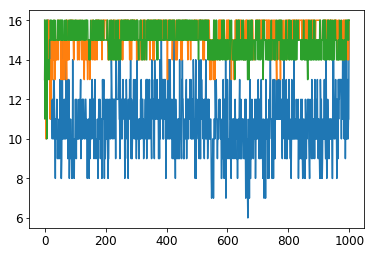

In [85]:
plt.plot(np.sum((Users_rsv_sa < 0.4),axis=0))
plt.plot(np.sum((Users_w_sa < 0.4),axis=0))
plt.plot(np.sum((GoT_Users_sa < 0.4),axis=0))


/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


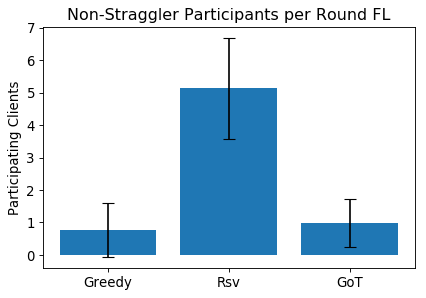

In [86]:
plt.figure(figsize=(6, 4), dpi=80)

# Sample data
labels = ['Greedy', 'Rsv', 'GoT']
values = [w_mean, rsv_mean, got_mean]
std_values = [w_std, rsv_std, got_std]

# Plotting the bar graph
plt.bar(labels, values, yerr=std_values, capsize=5)

# Adding labels and title
#  Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

# plt.xlabel('Categories')
plt.ylabel('Participating Clients')
plt.title('Non-Straggler Participants per Round FL')

# Display the graph
plt.show()

In [87]:
save_dict = {}
save_dict['Users_w_sa'] = Users_w_sa
save_dict['Users_rsv_sa'] = Users_rsv_sa
save_dict['GoT_Users_sa'] = GoT_Users_sa

with open("experiments/save/exp9/23_06_22_participant_array_4.pkl", "wb") as tf:
    pickle.dump(save_dict,tf)

In [ ]:
with open("experiments/save/exp9/23_06_22_participant_array_4.pkl", "wb") as tf:
    pickle.dump(save_dict,tf)

save_dict = {}
save_dict['Users_w_sa'] = Users_w_sa
save_dict['Users_rsv_sa'] = Users_rsv_sa
save_dict['GoT_Users_sa'] = GoT_Users_sa



/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


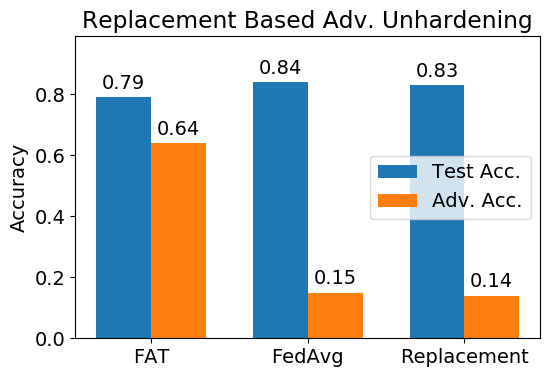

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bars
labels = ['FAT', 'FedAvg', 'Replacement']
bar1_values = [0.79, 0.84, 0.83]
bar2_values = [0.64, 0.15, 0.14]

# Position of the bars on the x-axis
x = np.arange(len(labels))

# Width of each bar
width = 0.35

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

# Plot the bars
rects1 = ax.bar(x - width/2, bar1_values, width, label='Test Acc.')
rects2 = ax.bar(x + width/2, bar2_values, width, label='Adv. Acc.')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Accuracy')
ax.set_title('Replacement Based Adv. Unhardening')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center right')
ax.set_ylim([0, 0.99])

# Add values on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


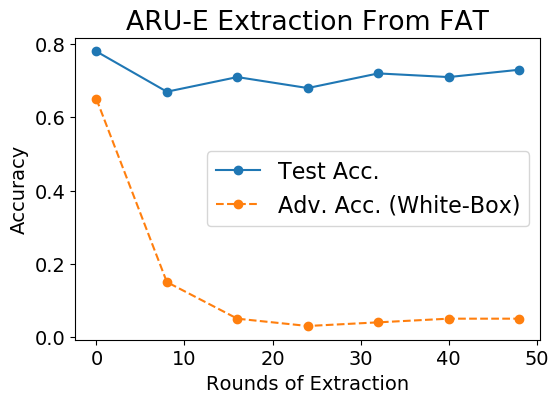

In [6]:
import matplotlib.pyplot as plt
import matplotlib

# Data for the lines
x = [0, 8, 16, 24, 32, 40, 48]
y1 = [0.78, 0.67, 0.71, 0.68, 0.72, 0.71, 0.73]
y2 = [0.65, 0.15, 0.05, 0.03, 0.04, 0.05, 0.05]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

# Plot the lines
ax.plot(x, y1, label='Test Acc.', marker = 'o')
ax.plot(x, y2, label='Adv. Acc. (White-Box)', marker = 'o', linestyle = '--')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

# Add some text for labels, title, and legend
ax.set_xlabel('Rounds of Extraction')
ax.set_ylabel('Accuracy')
ax.set_title('ARU-E Extraction From FAT')
ax.legend()

plt.show()
